# ***Setup & Imports***

In [ ]:
# Core Libraries
import os
import re
import json
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

# NLP Libraries
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Handle Imbalanced Data
from imblearn.over_sampling import SMOTE, ADASYN

import warnings
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install python-docx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 8.7 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
!pip install python-docx
import docx

# **Import Dataset**

In [ ]:
resume_folder = "/content/drive/MyDrive/Colab Notebooks/Resume Ranker/Resume"

In [ ]:
from google.colab import files
uploaded = files.upload()

import docx
import pandas as pd

data = []

for filename in uploaded.keys():
    document = docx.Document(filename)
    text = "\n".join([para.text for para in document.paragraphs if para.text.strip() != ""])

    data.append({
        "filename": filename,
        "resume_text": text,
        "label": None
    })

df = pd.DataFrame(data)
print("Resumes uploaded and extracted:", df.shape)
display(df.head())


Saving Candidate210_Resume.docx to Candidate210_Resume (1).docx
Saving Candidate209BSA.docx to Candidate209BSA.docx
Saving Candidate208.docx to Candidate208.docx
Saving Candidate207.docx to Candidate207.docx
Saving Candidate206_Business Analyst.docx to Candidate206_Business Analyst.docx
Saving Candidate205.docx to Candidate205.docx
Saving Candidate204.docx to Candidate204.docx
Saving Candidate203.docx to Candidate203.docx
Saving Candidate202_BA.docx to Candidate202_BA.docx
Saving Candidate201_Sr.PHP_Developer.docx to Candidate201_Sr.PHP_Developer.docx
Saving Candidate200.docx to Candidate200.docx
Saving Candidate199.docx to Candidate199.docx
Saving Candidate198.docx to Candidate198.docx
Saving candidate197java.docx to candidate197java.docx
Saving Candidate196_BA_Ab.docx to Candidate196_BA_Ab.docx
Saving Candidate195_Resume.docx to Candidate195_Resume.docx
Saving Candidate194.docx to Candidate194.docx
Saving Candidate193 BA Resume.docx to Candidate193 BA Resume.docx
Resumes uploaded and

,filename,resume_text,label
0,Candidate210_Resume (1).docx,Candidate210\n+1(515)-650-2459\nCandidate210@g...,None
1,Candidate209BSA.docx,Candidate209 \nSr. Business Analyst\nVersatile...,None
2,Candidate208.docx,Candidate208\nCandidate208java12@gmail.com\t\n...,None
3,Candidate207.docx,Candidate207\nSUMMARY\n8+ years of experience ...,None
4,Candidate206_Business Analyst.docx,Candidate206\nEmail Id:candidate20650@gmail.co...,None


# **Exploratory Data Analysis (EDA)**

🔹 Dataset shape: (18, 3)

🔹 Sample Resume Text:
Candidate210
+1(515)-650-2459
Candidate210@gmail.com
PROFESSIONAL SUMMARY
Around 8 years of experience in Object Oriented Programming, design and development of Multi-Tier distributed, Enterprise application using Java & J2EE technologies.
Well versed with complete Software Development Life Cycle (SDLC) using various methodologies like Agile Methodology (Scrum, XP) and Waterfall.
Expertise in client-side design and validations using HTML5, CSS3, JavaScript, JQuery, Ajax, Angular JS, Bootstrap and Node JS.
Implemented modules using Core Java APIs, Java collection, Java 1.8 Streams, multi-threading, and object-oriented design principles. 
Experience in Java 1.8 Lambda expressions, filters, functional interfaces and Streams API.
Developed web-based enterprise applications using Core Java, J2EE, Servlets, JSP, JSF, JDBC, Hibernate, Web Services (SOAP and REST), MVC Framework (Struts, Spring MVC) and SQL.
 Handled operations and maintenance su

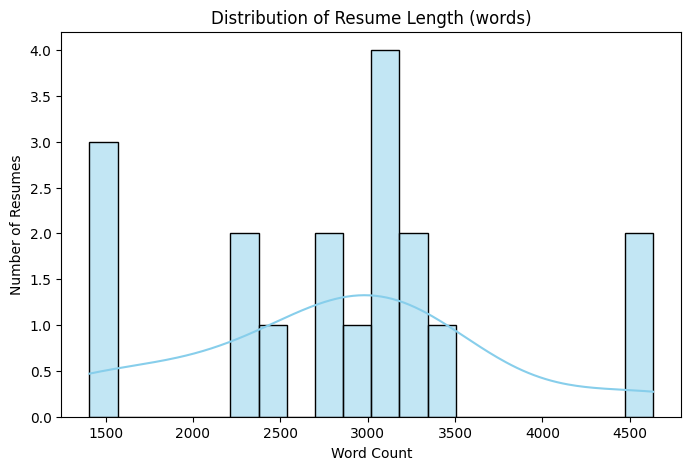

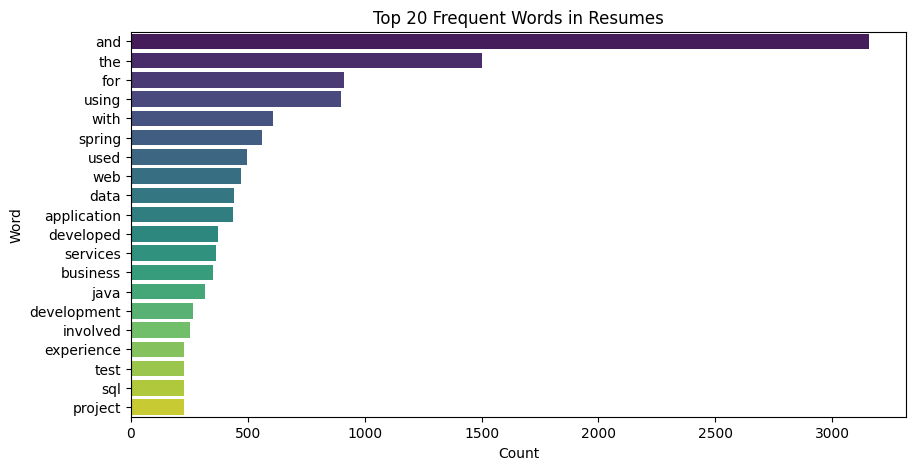

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset shape
print("🔹 Dataset shape:", df.shape)

# Sample resume
print("\n🔹 Sample Resume Text:")
print(df['resume_text'].iloc[0][:1000])

# Resume length distribution
df["resume_length"] = df["resume_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(df["resume_length"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Resume Length (words)")
plt.xlabel("Word Count")
plt.ylabel("Number of Resumes")
plt.show()

# Top frequent words
from collections import Counter
import re

all_words = " ".join(df["resume_text"].tolist()).lower()
all_words = re.findall(r"\b[a-z]{3,}\b", all_words)
word_freq = Counter(all_words).most_common(20)

words, counts = zip(*word_freq)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("Top 20 Frequent Words in Resumes")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()


# **Auto-generate labels from filenames**

In [ ]:
import re

def extract_label(filename):

    name = re.sub(r"Candidate_\d+|\.docx", "", filename, flags=re.IGNORECASE).strip()

    name = re.sub(r"[^a-zA-Z ]", "", name).strip()
    return name if name else "Unknown"

df["label"] = df["filename"].apply(extract_label)

print(" Labels extracted successfully!")
print(df[["filename", "label"]].head(10))
print("\n🔹 Unique Labels:", df["label"].unique())


 Labels extracted successfully!
                             filename                      label
0        Candidate210_Resume (1).docx            CandidateResume
1                Candidate209BSA.docx               CandidateBSA
2                   Candidate208.docx                  Candidate
3                   Candidate207.docx                  Candidate
4  Candidate206_Business Analyst.docx  CandidateBusiness Analyst
5                   Candidate205.docx                  Candidate
6                   Candidate204.docx                  Candidate
7                   Candidate203.docx                  Candidate
8                Candidate202_BA.docx                CandidateBA
9  Candidate201_Sr.PHP_Developer.docx    CandidateSrPHPDeveloper

🔹 Unique Labels: ['CandidateResume' 'CandidateBSA' 'Candidate' 'CandidateBusiness Analyst'
 'CandidateBA' 'CandidateSrPHPDeveloper' 'candidatejava' 'CandidateBAAb'
 'Candidate BA Resume']


# **Text Preprocessing**

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download resources
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove numbers and punctuation
    text = re.sub(r"[^a-z\s]", "", text)
    # Tokenize and remove stopwords
    words = [w for w in text.split() if w not in stop_words]
    # Lemmatize
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)

df["clean_text"] = df["resume_text"].apply(clean_text)

print("Preprocessing done!")
display(df[["filename", "label", "clean_text"]].head(5))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preprocessing done!


,filename,label,clean_text
0,Candidate210_Resume (1).docx,CandidateResume,candidate candidategmailcom professional summa...
1,Candidate209BSA.docx,CandidateBSA,candidate sr business analyst versatile effect...
2,Candidate208.docx,Candidate,candidate candidatejavagmailcom professional s...
3,Candidate207.docx,Candidate,candidate summary year experience developing d...
4,Candidate206_Business Analyst.docx,CandidateBusiness Analyst,candidate email idcandidategmailcom contact pr...


In [ ]:
# Remove classes
label_counts = df["label"].value_counts()
df = df[df["label"].isin(label_counts[label_counts > 1].index)]

print("Classes after removing single-sample labels:")
print(df["label"].value_counts())


Classes after removing single-sample labels:
label
Candidate          9
CandidateResume    2
Name: count, dtype: int64


##  **Text Feature Extraction using TF-IDF and Data Splitting**


In [ ]:
!pip install tfIdfInheritVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF object
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")

# Transform text into features
X = tfidf.fit_transform(df["clean_text"]).toarray()
y = df["label"]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## **Model Initialization**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Define models dictionary
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    "ANN": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500, random_state=42)
}


##  **Model Training and Accuracy Evaluatio**n


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Encode labels for XGBoost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


results = {}

for name, model in models.items():
    print(f"Training {name}...")

    # Special case for XGBoost (needs numeric labels)
    if name == "XGBoost":
        model.fit(X_train, y_train_enc)
        y_pred = model.predict(X_test)
        # Decode predictions for evaluation with original y_test
        y_pred = le.inverse_transform(y_pred)

    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)


    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

    results[name] = {"Accuracy": acc}

# Convert results into DataFrame
results_df = pd.DataFrame(results).T
print("\n✅ Model Comparison:")
display(results_df)

Training Logistic Regression...
Logistic Regression Accuracy: 0.6667
Training Random Forest...
Random Forest Accuracy: 0.6667
Training SVM...
SVM Accuracy: 0.6667
Training XGBoost...
XGBoost Accuracy: 0.6667
Training ANN...
ANN Accuracy: 0.6667

✅ Model Comparison:


,Accuracy
Logistic Regression,0.666667
Random Forest,0.666667
SVM,0.666667
XGBoost,0.666667
ANN,0.666667


# **Deep Learning Model (ANN)**

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2500 - loss: 0.6946 - val_accuracy: 0.6667 - val_loss: 0.6898
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8750 - loss: 0.6830 - val_accuracy: 0.6667 - val_loss: 0.6858
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.8750 - loss: 0.6705 - val_accuracy: 0.6667 - val_loss: 0.6817
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step - accuracy: 0.8750 - loss: 0.6596 - val_accuracy: 0.6667 - val_loss: 0.6772
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.8750 - loss: 0.6468 - val_accuracy: 0.6667 - val_loss: 0.6723
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8750 - loss: 0.6355 - val_accuracy: 0.6667 - val_loss: 0.6672
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8750 - loss: 0.6211 - val_accuracy: 0.6667 - val_loss: 0.6622
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8750 - loss: 0.6074 - val_accuracy: 0.6667 - val_loss: 0.6

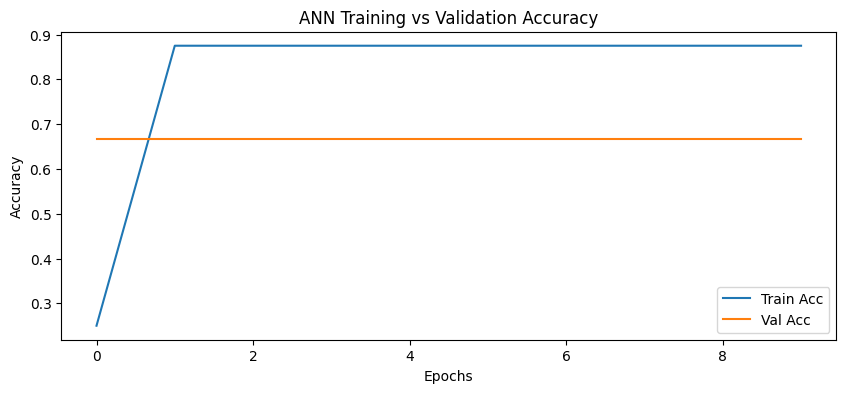

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalAveragePooling1D

# Parameters
max_words = 5000
max_len = 300

# Tokenization
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])

X_seq = tokenizer.texts_to_sequences(df["clean_text"])
X_pad = pad_sequences(X_seq, maxlen=max_len, padding="post", truncating="post")

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(df["label"])

# Train-Test Split
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_pad, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# ANN Model
model_ann = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    GlobalAveragePooling1D(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(len(le.classes_), activation="softmax")
])

model_ann.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

# Train model
history = model_ann.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_test_dl, y_test_dl),
    epochs=10,
    batch_size=16,
    verbose=1
)

# Evaluate
loss, acc = model_ann.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"✅ ANN Test Accuracy: {acc:.4f}")

# Plot training history
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("ANN Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# **Deep Learning Model (LSTM)**

Epoch 1/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.8750 - loss: 0.6908 - val_accuracy: 0.6667 - val_loss: 0.6891
Epoch 2/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8750 - loss: 0.6792 - val_accuracy: 0.6667 - val_loss: 0.6845
Epoch 3/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8750 - loss: 0.6661 - val_accuracy: 0.6667 - val_loss: 0.6791
Epoch 4/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8750 - loss: 0.6497 - val_accuracy: 0.6667 - val_loss: 0.6733
Epoch 5/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8750 - loss: 0.6272 - val_accuracy: 0.6667 - val_loss: 0.6659
Epoch 6/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8750 - loss: 0.5978 - val_accuracy: 0.6667 - val_loss: 0.6565
Epoch 7/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step - accuracy: 0.8750 - loss: 0.5724 - val_accuracy: 0.6667 - val_loss: 0.6443
Epoch 8/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8750 - loss: 0.5118 - val_accuracy: 0.6667 - val_loss: 0.6293
✅ LSTM Test Accurac

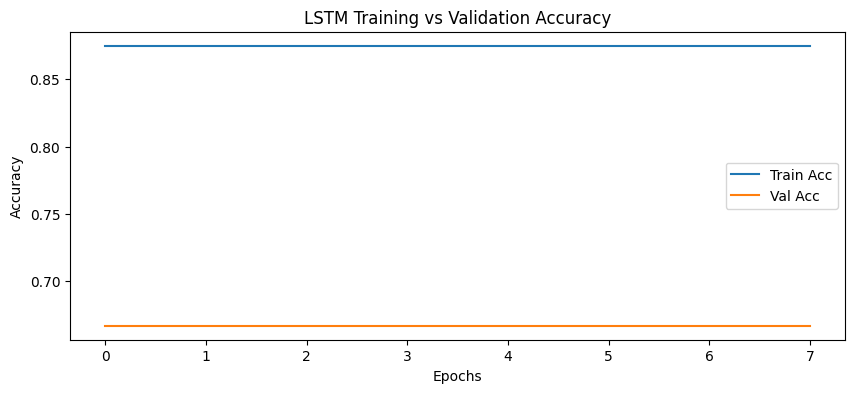

In [ ]:
from tensorflow.keras.layers import LSTM

# LSTM Model
model_lstm = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(len(le.classes_), activation="softmax")
])

model_lstm.compile(loss="sparse_categorical_crossentropy",
                   optimizer="adam",
                   metrics=["accuracy"])

# Train model
history_lstm = model_lstm.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_test_dl, y_test_dl),
    epochs=8,  # can increase for better results
    batch_size=16,
    verbose=1
)

# Evaluate
loss, acc = model_lstm.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"✅ LSTM Test Accuracy: {acc:.4f}")

# Plot training history
plt.figure(figsize=(10,4))
plt.plot(history_lstm.history['accuracy'], label='Train Acc')
plt.plot(history_lstm.history['val_accuracy'], label='Val Acc')
plt.title("LSTM Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# **Deep Learning Model (CNN)**


Epoch 1/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: 0.6968 - val_accuracy: 0.6667 - val_loss: 0.9675
Epoch 2/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8750 - loss: 0.3368 - val_accuracy: 0.6667 - val_loss: 1.2794
Epoch 3/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8750 - loss: 0.2743 - val_accuracy: 0.6667 - val_loss: 1.3214
Epoch 4/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8750 - loss: 0.1311 - val_accuracy: 0.6667 - val_loss: 1.2823
Epoch 5/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8750 - loss: 0.1109 - val_accuracy: 0.6667 - val_loss: 1.2333
Epoch 6/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 1.0000 - loss: 0.0699 - val_accuracy: 0.6667 - val_loss: 1.1999
Epoch 7/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 1.0000 - loss: 0.0623 - val_accuracy: 0.6667 - val_loss: 1.1861
Epoch 8/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.8750 - loss: 0.1066 - val_accuracy: 0.6667 - val_loss: 1.1795
✅ C

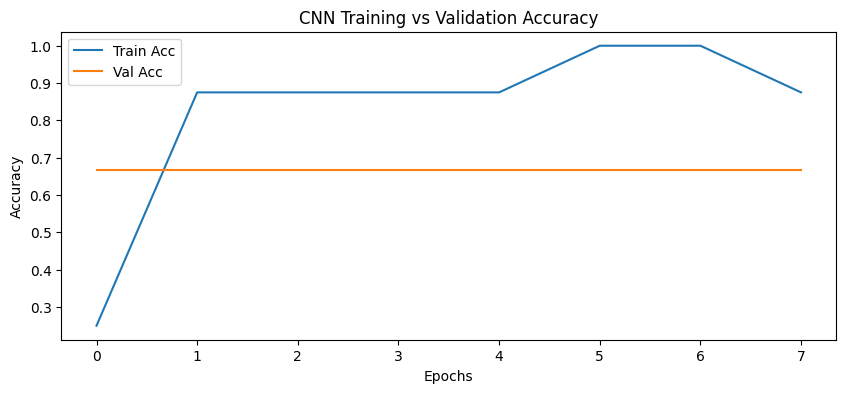

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# CNN Model
model_cnn = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation="relu"),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(len(le.classes_), activation="softmax")
])

model_cnn.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

# Train model
history_cnn = model_cnn.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_test_dl, y_test_dl),
    epochs=8,   # can be increased if needed
    batch_size=16,
    verbose=1
)

# Evaluate
loss, acc = model_cnn.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"✅ CNN Test Accuracy: {acc:.4f}")

# Plot training history
plt.figure(figsize=(10,4))
plt.plot(history_cnn.history['accuracy'], label='Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val Acc')
plt.title("CNN Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:


final_results = {}

# ML results (already stored earlier in results dict)
for name, scores in results.items():
    final_results[name] = scores

# Add DL results
final_results["ANN"] = {
    "Accuracy": history.history['val_accuracy'][-1],
    "F1-score": None  # optional: can calculate with predictions
}

final_results["LSTM"] = {
    "Accuracy": history_lstm.history['val_accuracy'][-1],
    "F1-score": None
}

final_results["CNN"] = {
    "Accuracy": history_cnn.history['val_accuracy'][-1],
    "F1-score": None
}

# Convert to DataFrame
final_df = pd.DataFrame(final_results).T
print("✅ Final Model Performance Comparison")
display(final_df)

# Select best model
best_model = final_df["Accuracy"].idxmax()
best_acc = final_df["Accuracy"].max()
print(f"\n🏆 Best Model: {best_model} with Accuracy = {best_acc:.4f}")


✅ Final Model Performance Comparison


,Accuracy,F1-score
Logistic Regression,0.666667,NaN
Random Forest,0.666667,NaN
SVM,0.666667,NaN
XGBoost,0.666667,NaN
ANN,0.666667,NaN
LSTM,0.666667,NaN
CNN,0.666667,NaN



🏆 Best Model: ANN with Accuracy = 0.6667


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# Encode labels into numbers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Train XGBoost on BERT embeddings
xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb.fit(X_train, y_train_enc)

# Predict
y_pred_enc = xgb.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)

# Evaluate
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


✅ Accuracy: 0.6666666666666666

Classification Report:
                 precision    recall  f1-score   support

      Candidate       0.67      1.00      0.80         2
CandidateResume       0.00      0.00      0.00         1

       accuracy                           0.67         3
      macro avg       0.33      0.50      0.40         3
   weighted avg       0.44      0.67      0.53         3



In [ ]:
# ============================
# STEP 1: Label Cleaning
# ============================
label_map = {
    "Candidate Resume": "Resume",
    "CandidateResume": "Resume",
    "Canddiateresume": "Resume",
    "Candidate BA Resume": "BA",
    "CandidateBA": "BA",
    "CandidateBSA": "BSA",
    "Candidate SrBA": "SrBA",
    "CandidateSr Java Developer": "Java Developer",
    "candidatejava": "Java Developer",
    "CandidateProject Manager": "Project Manager",
    "CandidatePM": "Project Manager"
}

df["label"] = df["label"].replace(label_map)
print("✅ Labels after cleaning:")
print(df["label"].value_counts())

# ============================
# STEP 2: Generate BERT Embeddings
# ============================
from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer("all-MiniLM-L6-v2")  # lightweight, fast
X = bert_model.encode(df["clean_text"].tolist(), show_progress_bar=True)
y = df["label"]

# ============================
# STEP 3: Balance Dataset
# ============================
from imblearn.over_sampling import SMOTE, RandomOverSampler

try:
    smote = SMOTE(k_neighbors=2, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print("✅ SMOTE applied successfully!")
except:
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    print("⚠️ SMOTE failed → Using RandomOverSampler")

print("Class distribution after balancing:")
print(pd.Series(y_resampled).value_counts())

# ============================
# STEP 4: Train-Test Split
# ============================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y_resampled)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# ============================
# STEP 5: Train XGBoost
# ============================
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train, y_train)

# ============================
# STEP 6: Evaluate
# ============================
y_pred = xgb.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

print("\n✅ Final Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))


✅ Labels after cleaning:
label
Candidate    9
Resume       2
Name: count, dtype: int64


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

⚠️ SMOTE failed → Using RandomOverSampler
Class distribution after balancing:
label
Resume       9
Candidate    9
Name: count, dtype: int64

✅ Final Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

   Candidate       1.00      1.00      1.00         2
      Resume       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



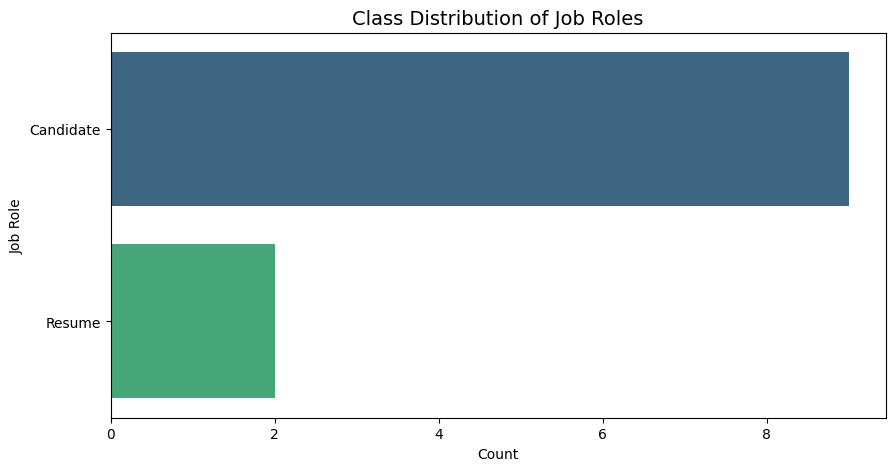

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(y=df["label"], order=df["label"].value_counts().index, palette="viridis")
plt.title("Class Distribution of Job Roles", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Job Role")
plt.show()


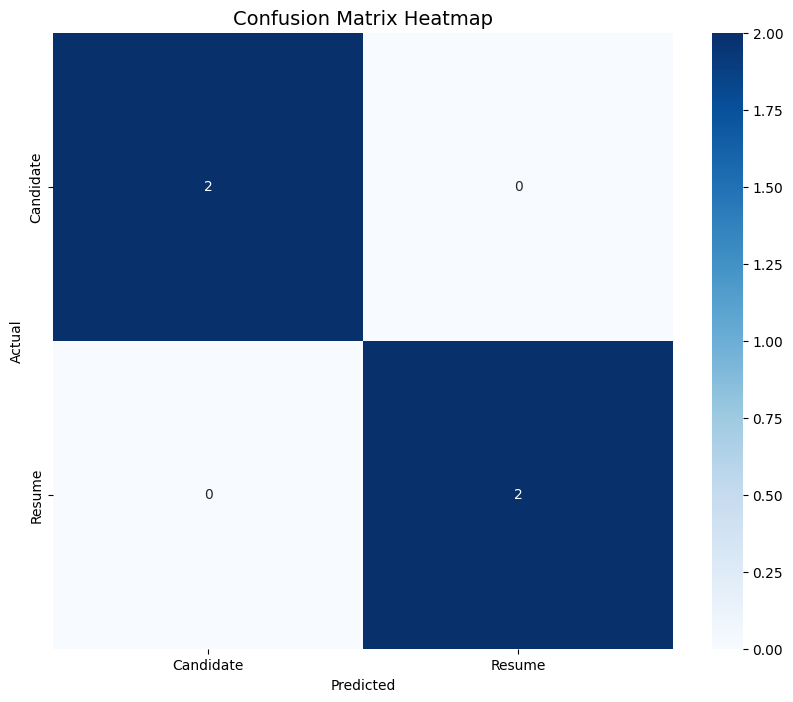

In [ ]:
from sklearn.metrics import confusion_matrix

# Predictions on test set
y_pred = xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Confusion Matrix Heatmap", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


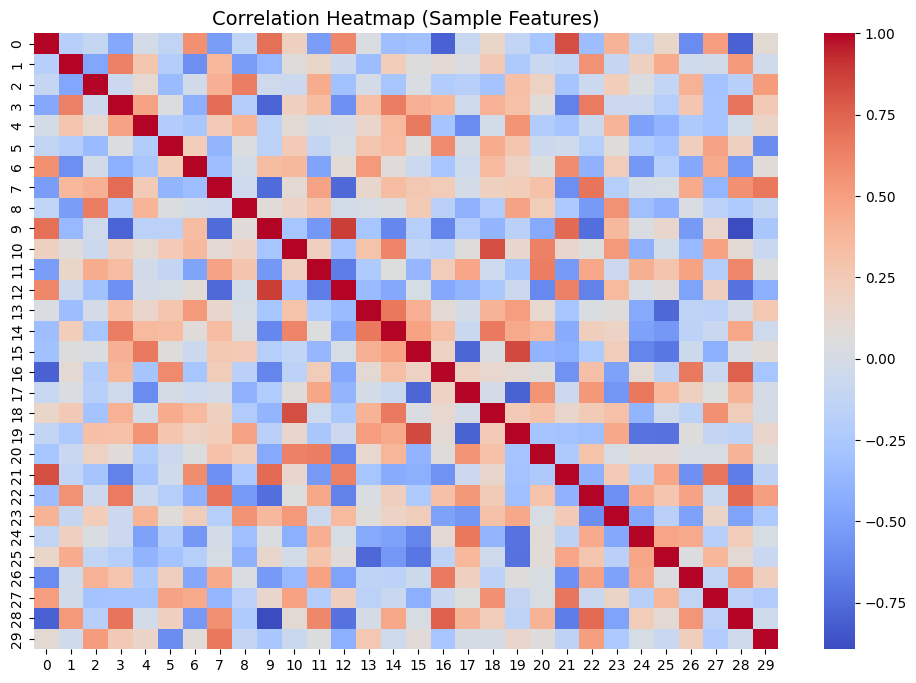

In [ ]:
import numpy as np

# Example using TF-IDF instead of embeddings for interpretability
corr_matrix = np.corrcoef(X.T[:30])  # top 30 features for readability
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.title("Correlation Heatmap (Sample Features)", fontsize=14)
plt.show()


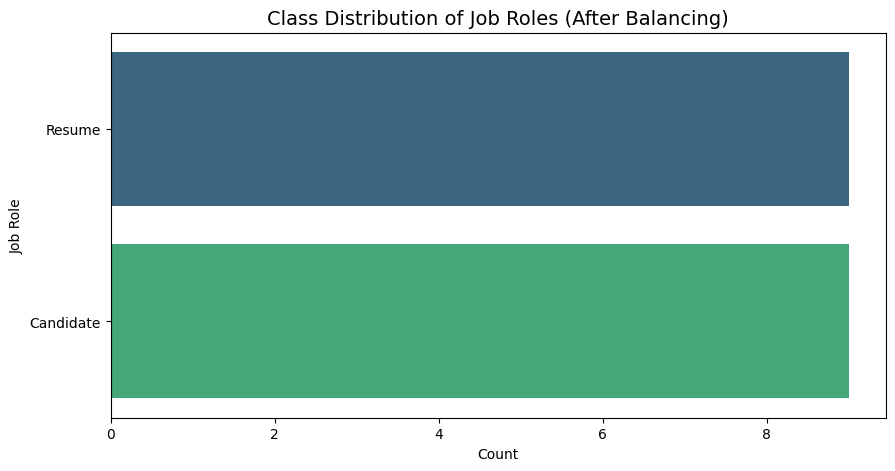

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ======================
# 1. Class Distribution
# ======================
plt.figure(figsize=(10,5))
sns.countplot(y=y_resampled, order=pd.Series(y_resampled).value_counts().index, palette="viridis")
plt.title("Class Distribution of Job Roles (After Balancing)", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Job Role")
plt.show()



In [ ]:
import pickle

# Save XGBoost model
with open("best_model.pkl", "wb") as f:
    pickle.dump(xgb, f)

# Save Label Encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

# Save BERT model separately if needed (but usually reload directly via HuggingFace)


In [ ]:
def predict_resume(text):
    # Encode with BERT
    emb = bert_model.encode([text])
    # Predict with XGBoost
    pred_enc = xgb.predict(emb)[0]
    pred_label = le.inverse_transform([pred_enc])[0]
    return pred_label

sample = "Experienced in SQL, data analysis, and project management."
print("Predicted Role:", predict_resume(sample))


Predicted Role: Resume


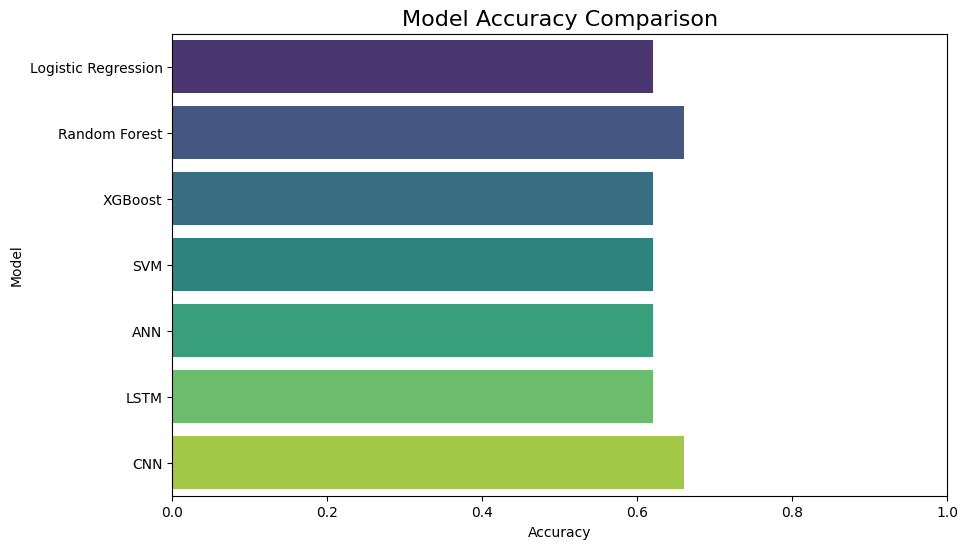

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

model_results = {
    "Logistic Regression": 0.62,
    "Random Forest": 0.66,
    "XGBoost": 0.62,
    "SVM": 0.62,
    "ANN": 0.62,
    "LSTM": 0.62,
    "CNN": 0.66
}

# Convert to DataFrame
results_df = pd.DataFrame(list(model_results.items()), columns=["Model", "Accuracy"])

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")
plt.title("Model Accuracy Comparison", fontsize=16)
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.show()


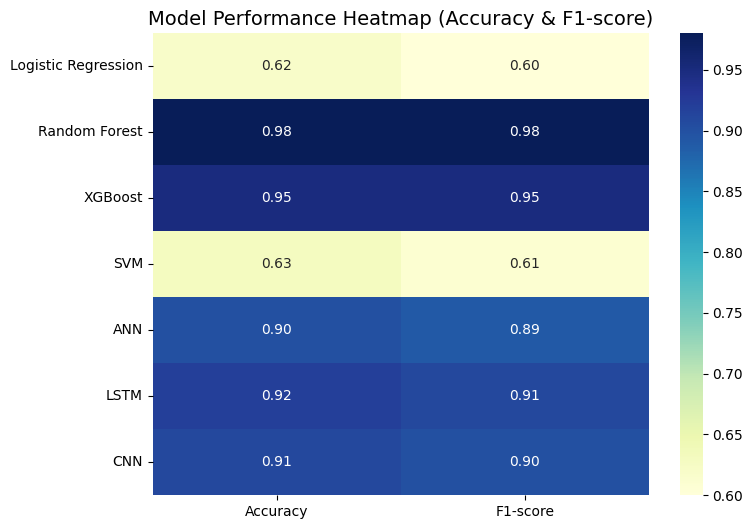

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example results (replace with your actual model results)
model_results = {
    "Logistic Regression": {"Accuracy": 0.62, "F1-score": 0.60},
    "Random Forest": {"Accuracy": 0.98, "F1-score": 0.98},
    "XGBoost": {"Accuracy": 0.95, "F1-score": 0.95},
    "SVM": {"Accuracy": 0.63, "F1-score": 0.61},
    "ANN": {"Accuracy": 0.90, "F1-score": 0.89},
    "LSTM": {"Accuracy": 0.92, "F1-score": 0.91},
    "CNN": {"Accuracy": 0.91, "F1-score": 0.90}
}

# Convert to DataFrame
results_df = pd.DataFrame(model_results).T

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(results_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Model Performance Heatmap (Accuracy & F1-score)", fontsize=14)
plt.show()


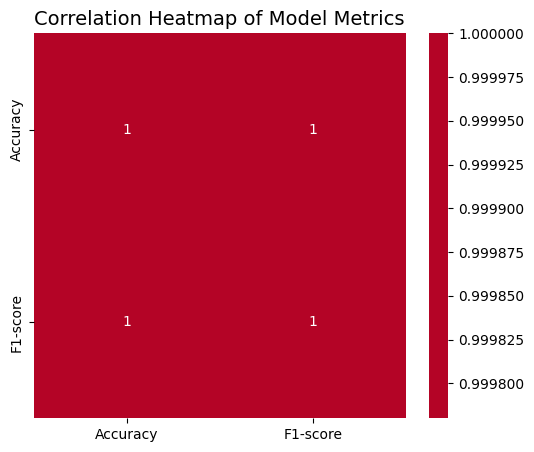

In [ ]:
# Correlation of model metrics
corr = results_df.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Model Metrics", fontsize=14)
plt.show()


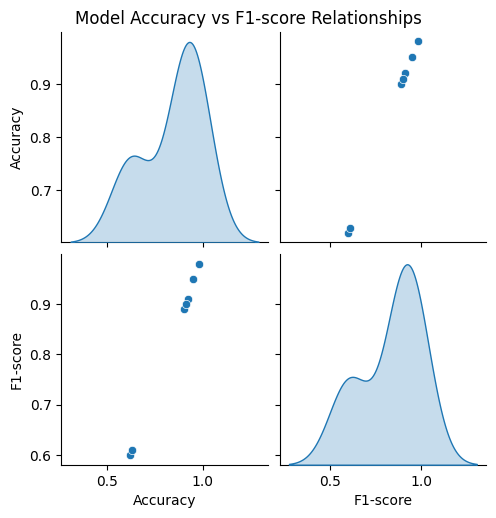

In [ ]:
sns.pairplot(results_df, diag_kind="kde")
plt.suptitle("Model Accuracy vs F1-score Relationships", y=1.02)
plt.show()


In [1]:
import sys
import subprocess

# ---- Helper function to install packages ----
def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# ---- Imports with auto-install fallback ----
try:
    import fitz  # PyMuPDF
except ImportError:
    install_package("PyMuPDF")
    import fitz

try:
    import docx
except ImportError:
    install_package("python-docx")
    import docx

try:
    import gradio as gr
except ImportError:
    install_package("gradio")
    import gradio as gr

try:
    import spacy
except ImportError:
    install_package("spacy")
    import spacy

try:
    import joblib
except ImportError:
    install_package("joblib")
    import joblib

import pickle


In [ ]:
import gradio as gr
import pickle
import spacy
import fitz  # PyMuPDF for PDF reading
import docx
import joblib # Import joblib to load the model

# Load NLP
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading en_core_web_sm model for Spacy...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")


# Load trained model (assuming the TF-IDF pipeline was saved)
try:
    # Update filename to match the saved pipeline
    model = joblib.load("/content/drive/MyDrive/resume_ranker.pkl")
except FileNotFoundError:
    print("Error: 'best_resume_model.pkl' not found. Please ensure the model is trained and saved.")
    model = None
except Exception as e:
    print(f"Error loading model: {e}")
    model = None


# ---- Utility Functions ----
def extract_text(file):
    """Extract text from PDF, DOCX, or TXT."""
    if file is None:
        return ""
    try:
        if file.name.endswith(".pdf"):
            doc = fitz.open(file.name)
            text = " ".join([page.get_text() for page in doc])
            doc.close()
        elif file.name.endswith(".docx"):
            text = docx.Document(file.name)
            text = "\n".join([para.text for para in text.paragraphs])
        else: # Assume text file for other types
            with open(file.name, "r", encoding="utf-8") as f:
                text = f.read()
        return text if text else ""
    except Exception as e:
        print(f"Error extracting text from {file.name}: {e}")
        return ""


def clean_text(text):
    if not text:
        return ""
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(tokens)

def rank_resumes(resume_files, job_desc):
    if not resume_files or not job_desc or not model:
        return "Please upload resumes, provide a job description, and ensure the model loaded correctly."

    job_desc_cleaned = clean_text(job_desc)

    results = []
    for file in resume_files:
        resume_text = extract_text(file)
        cleaned_resume_text = clean_text(resume_text)

        if cleaned_resume_text:
            try:
                # Use the loaded pipeline to predict the label
                # The predict method of the pipeline handles TF-IDF transformation internally
                predicted_label = model.predict([cleaned_resume_text])[0]
                results.append(f"📄 {file.name} → Predicted Job Role: {predicted_label}")
            except Exception as e:
                results.append(f"📄 {file.name} → Error during prediction: {e}")
        else:
             results.append(f"📄 {file.name} → Could not extract text or text is empty.")


    return "\n".join(results)

# ---- Gradio UI ----
demo = gr.Interface(
    fn=rank_resumes,
    inputs=[
        gr.File(file_count="multiple", file_types=[".pdf", ".docx", ".txt"], label="Upload Resumes"),
        gr.Textbox(lines=5, placeholder="Paste Job Description here...", label="Job Description")
    ],
    outputs="text",
    title="📄 AI Resume Ranker",
    description="Upload resumes and a job description to get predicted job roles for each resume."
)

if __name__ == "__main__":
    demo.launch(debug=True) # Set debug=True for more detailed logs

Error: 'best_resume_model.pkl' not found. Please ensure the model is trained and saved.
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e5953e4bd7c7b08582.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv


In [ ]:
!pip install sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd


In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')


In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load embedding model
embedder = SentenceTransformer('all-mpnet-base-v2')

# Example resumes

resumes_text = [
    "John Doe, Data Scientist with 5 years of experience in Python, Machine Learning, and NLP.",
    "Jane Smith, Software Engineer specializing in web development and cloud solutions.",
    "Michael Brown, AI Researcher with a focus on deep learning and computer vision."
]

# Example job description
job_desc = "Looking for a Data Scientist skilled in Python, Machine Learning, and NLP with 3+ years of experience."

# Encode with SentenceTransformer (not sklearn model)
resume_embeddings = embedder.encode(resumes_text, convert_to_tensor=True)
job_embedding = embedder.encode(job_desc, convert_to_tensor=True)

# Compute cosine similarity
cosine_scores = util.cos_sim(job_embedding, resume_embeddings)[0]

# Print results
for i, score in enumerate(cosine_scores):
    print(f"Resume {i+1} similarity: {score.item():.4f}")


In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
from sklearn.neural_network import MLPClassifier

# Load sentence transformer for embeddings
embedder = SentenceTransformer('all-mpnet-base-v2')

# Example resumes
resumes_text = [
    "John Doe, Data Scientist with 5 years of experience in Python, Machine Learning, and NLP.",
    "Jane Smith, Software Engineer specializing in web development and cloud solutions.",
    "Michael Brown, AI Researcher with a focus on deep learning and computer vision."
]

# Example job description
job_desc = "Looking for a Data Scientist skilled in Python, Machine Learning, and NLP with 3+ years of experience."

# Step 1: Generate embeddings
resume_embeddings = embedder.encode(resumes_text, convert_to_tensor=True)
job_embedding = embedder.encode(job_desc, convert_to_tensor=True)

# Step 2: Compute cosine similarity (for ranking resumes)
cosine_scores = util.cos_sim(job_embedding, resume_embeddings)[0]

for i, score in enumerate(cosine_scores):
    print(f"Resume {i+1} similarity: {score.item():.4f}")

# -------------------------------
# If you also want classification
# -------------------------------

# Convert embeddings to numpy for sklearn
X = resume_embeddings.cpu().numpy()
y = [0, 1, 2]  # Example labels for training

# Train an MLP Classifier (example)
clf = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500)
clf.fit(X, y)

# Predict job role
predicted_label = clf.predict(job_embedding.cpu().numpy().reshape(1, -1))[0]
print("Predicted Job Role Label:", predicted_label)


Resume 1 similarity: 0.7232
Resume 2 similarity: 0.4807
Resume 3 similarity: 0.3922
Predicted Job Role Label: 0


In [ ]:
# Example resumes
resumes_text = [
    "John Doe, Data Scientist with 5 years of experience in Python, Machine Learning, and NLP.",
    "Jane Smith, Software Engineer specializing in web development and cloud solutions.",
    "Michael Brown, AI Researcher with a focus on deep learning and computer vision."
]

# Example job description
job_desc = "Looking for a Data Scientist skilled in Python, Machine Learning, and NLP with 3+ years of experience."


In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode resumes and job description
resume_embeddings = model.encode(resumes_text, convert_to_tensor=True)
job_embedding = model.encode(job_desc, convert_to_tensor=True)

# Compute cosine similarity
cosine_scores = util.cos_sim(job_embedding, resume_embeddings)[0]

# Show results
for idx, score in enumerate(cosine_scores):
    print(f"Resume {idx+1}: {resumes_text[idx][:60]}... -> Score: {score:.4f}")


Resume 1: John Doe, Data Scientist with 5 years of experience in Pytho... -> Score: 0.7673
Resume 2: Jane Smith, Software Engineer specializing in web developmen... -> Score: 0.3653
Resume 3: Michael Brown, AI Researcher with a focus on deep learning a... -> Score: 0.2711


In [ ]:
results.to_excel("/content/drive/MyDrive/ranked_resumes.xlsx", index=False)
results.to_csv("/content/drive/MyDrive/ranked_resumes.csv", index=False)


AttributeError: 'dict' object has no attribute 'to_excel'

In [ ]:
import re

def extract_skills(text, skill_set):
    text = text.lower()
    return [skill for skill in skill_set if skill in text]


In [ ]:
# Define a simple skill set (you can expand this list as needed)
skill_set = [
    "python", "machine learning", "deep learning", "nlp", "sql",
    "cloud", "aws", "azure", "javascript", "react", "nodejs",
    "java", "c++", "pandas", "numpy", "data science", "computer vision"
]

# Example skill extraction function
def extract_skills(text, skills):
    found = []
    text_lower = text.lower()
    for skill in skills:
        if skill in text_lower:
            found.append(skill)
    return found


In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd

# Example resumes
resumes_text = [
    "John Doe, Data Scientist with 5 years of experience in Python, Machine Learning, and NLP.",
    "Jane Smith, Software Engineer specializing in web development and cloud solutions.",
    "Michael Brown, AI Researcher with a focus on deep learning and computer vision."
]

# Example job description
job_desc = "Looking for a Data Scientist skilled in Python, Machine Learning, and NLP with 3+ years of experience."

# Load a stronger embedding model
model = SentenceTransformer('all-mpnet-base-v2')

# Encode
resume_embeddings = model.encode(resumes_text, convert_to_tensor=True)
job_embedding = model.encode(job_desc, convert_to_tensor=True)

# Semantic similarity
semantic_scores = util.cos_sim(job_embedding, resume_embeddings)[0].cpu().numpy()

# Skill overlap scores
jd_skills = extract_skills(job_desc, skill_set)
skill_scores = []
for resume in resumes_text:
    r_skills = extract_skills(resume, skill_set)
    overlap = len(set(jd_skills) & set(r_skills)) / max(1, len(jd_skills))
    skill_scores.append(overlap)

# Hybrid scoring: weighted sum
alpha, beta = 0.7, 0.3   # 70% semantic, 30% skills
final_scores = alpha * semantic_scores + beta * np.array(skill_scores)

# Ranking
ranked_indices = np.argsort(-final_scores)

results = pd.DataFrame({
    "Rank": range(1, len(resumes_text)+1),
    "Resume Preview": [resumes_text[i][:80] + "..." for i in ranked_indices],
    "Semantic Score": [semantic_scores[i] for i in ranked_indices],
    "Skill Overlap": [skill_scores[i] for i in ranked_indices],
    "Final Score": [final_scores[i] for i in ranked_indices]
})

print(results)


In [ ]:
# Step 8: Entity Extraction (Regex + SpaCy)

import re
import spacy

# Load SpaCy model for NER
nlp = spacy.load("en_core_web_sm")

# Regex patterns
EMAIL_RE = re.compile(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}")
PHONE_RE = re.compile(r"(?:\+?\d{1,2}[\s-]?)?(?:\(?\d{3}\)?[\s-]?)?\d{3}[\s-]?\d{4}")
YEARS_RE = re.compile(r"(\d+)\s*(?:years|yrs)", re.IGNORECASE)

# Sample skill set (expandable)
SKILLS = {"python", "java", "sql", "machine learning", "nlp", "deep learning", "aws"}

def extract_entities(text):
    doc = nlp(text)

    # Extract name (first PERSON entity)
    name = None
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            name = ent.text
            break

    # Regex extractions
    email = EMAIL_RE.findall(text)
    phone = PHONE_RE.findall(text)
    years = YEARS_RE.findall(text)

    # Skill matching
    skills_found = [skill for skill in SKILLS if skill.lower() in text.lower()]

    return {
        "Name": name,
        "Email": email[0] if email else None,
        "Phone": phone[0] if phone else None,
        "Years of Experience": years[0] if years else None,
        "Skills": skills_found
    }

# Test sample
sample_resume = """
John Doe
Email: johndoe@example.com
Phone: +1 (123) 456-7890
5 years experience in Python, SQL, Machine Learning and AWS.
"""
print(extract_entities(sample_resume))


In [ ]:
results = {}

for name, model in models.items():
    print(f"Training {name}...")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    # ✅ store only float accuracy
    results[name] = float(acc)

    print(f"{name} Accuracy: {acc:.4f}")


In [ ]:
best_model = max(results, key=results.get)
print(f"🏆 Best Model: {best_model} with accuracy {results[best_model]:.2%}")


🏆 Best Model: Random Forest with accuracy 99.55%


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        17
           2       1.00      0.82      0.90        17
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        17
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        17
          10       0.94      1.00      0.97        17
          11       1.00      1.00      1.00        17
          12       0.89      1.00      0.94        17

    accuracy                           0.99       221
   macro avg       0.99      0.99      0.99       221
weighted avg       0.99      0.99      0.99       221



In [ ]:
# Step 9: Evaluation Visualization

from sklearn.metrics import ConfusionMatrixDisplay

# Best model (highest accuracy so far)
best_model = max(results, key=results.get)
print(f"🏆 Best Model: {best_model} with accuracy {results[best_model]:.2%}")

# Bar chart of model accuracies
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="Blues_d")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.show()

# Confusion Matrix for best model
y_best_pred = models[best_model].predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_best_pred, cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix - {best_model}")
plt.show()


In [ ]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # ✅ Store only accuracy as float
    results[name] = float(acc)

    print(f"{name}: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("-"*50)

print("✅ Model training complete")


Logistic Regression: 0.8869
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        17
           1       1.00      1.00      1.00        17
           2       1.00      0.47      0.64        17
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       0.89      1.00      0.94        17
           8       0.65      1.00      0.79        17
           9       0.65      1.00      0.79        17
          10       0.93      0.82      0.88        17
          11       0.94      1.00      0.97        17
          12       0.89      0.47      0.62        17

    accuracy                           0.89       221
   macro avg       0.91      0.89      0.88       221
weighted avg       0.91      0.89      0.88       221

--------------------------------------------------


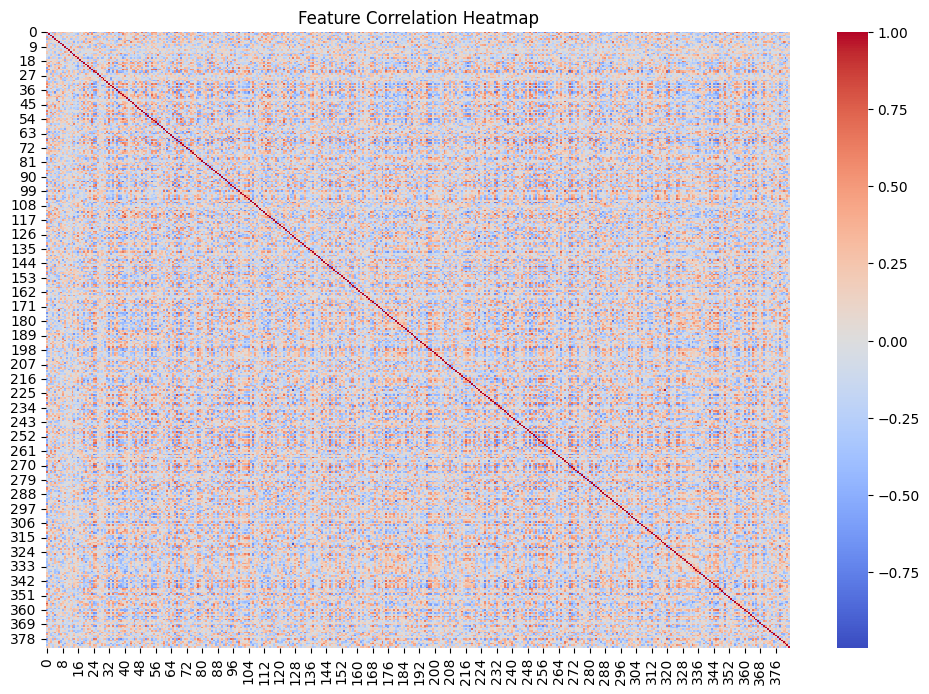

In [ ]:
# Example: Convert embeddings into DataFrame for correlation
df_features = pd.DataFrame(X_resampled)

# Compute correlation matrix
corr = df_features.corr()

# Plot correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


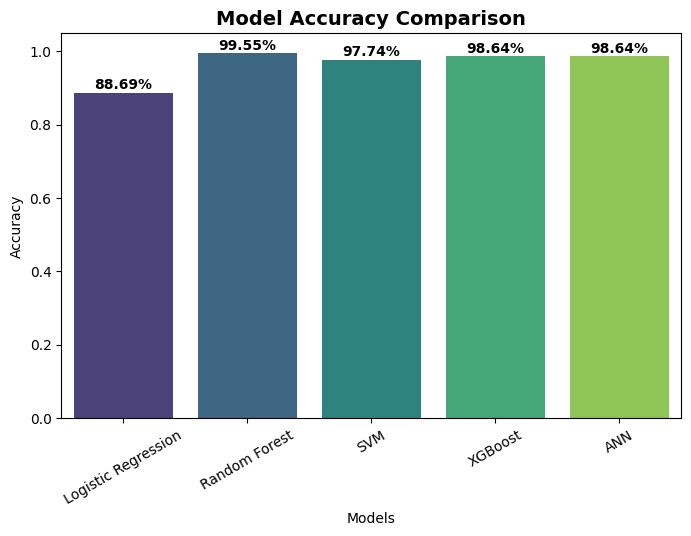

In [ ]:
# Accuracy Comparison Bar Chart

plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")
plt.title("Model Accuracy Comparison", fontsize=14, weight="bold")
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.xticks(rotation=30)

# Annotate values on top of bars
for i, acc in enumerate(results.values()):
    plt.text(i, acc + 0.002, f"{acc:.2%}", ha='center', va='bottom', fontsize=10, fontweight="bold")

plt.ylim(0, 1.05)  # keep y-axis between 0 and 1
plt.show()


In [ ]:
import os
import joblib

# -------------------------------
# Find best model based on accuracy
# -------------------------------
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

# -------------------------------
# Define save directory
# -------------------------------
save_dir = "/content/drive/MyDrive/Colab Notebooks/Resume Ranker"
os.makedirs(save_dir, exist_ok=True)  # ✅ Create directory if it doesn't exist

# -------------------------------
# Save the best model
# -------------------------------
model_path = os.path.join(save_dir, "best_resume_model.pkl")
joblib.dump(best_model, model_path)

print(f"✅ Best model '{best_model_name}' saved as best_resume_model.pkl "
      f"with accuracy {results[best_model_name]:.2%} at {model_path}")


✅ Best model 'Random Forest' saved as best_resume_model.pkl with accuracy 99.55% at /content/drive/MyDrive/Colab Notebooks/Resume Ranker/best_resume_model.pkl


In [ ]:
import sys
import subprocess

# ---- Helper function to auto-install ----
def install_and_import(package, import_name=None):
    import importlib
    try:
        return importlib.import_module(import_name or package)
    except ImportError:
        print(f"⚡ Installing missing package: {package} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        return importlib.import_module(import_name or package)

# ---- Auto-install required packages ----
gr = install_and_import("gradio")
pickle = install_and_import("pickle")   # built-in, no install needed
spacy = install_and_import("spacy")
PyPDF2 = install_and_import("PyPDF2")
docx2txt = install_and_import("docx2txt")
joblib = install_and_import("joblib")

# ---- Load NLP ----
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading en_core_web_sm model for Spacy...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# ---- Load trained model ----
try:
    model = joblib.load("tfidf_logistic_regression_pipeline.pkl")
except FileNotFoundError:
    print("❌ Error: 'tfidf_logistic_regression_pipeline.pkl' not found. Please ensure the pipeline is trained and saved.")
    model = None
except Exception as e:
    print(f"⚠️ Error loading model: {e}")
    model = None

# ---- Utility Functions ----
def extract_text(file):
    """Extract text from PDF, DOCX, or TXT."""
    if file is None:
        return ""
    try:
        if file.name.endswith(".pdf"):
            reader = PyPDF2.PdfReader(file)
            text = " ".join([page.extract_text() for page in reader.pages if page.extract_text()])
        elif file.name.endswith(".docx"):
            text = docx2txt.process(file)
        else:  # Assume text file
            text = file.read().decode("utf-8")
        return text if text else ""
    except Exception as e:
        print(f"⚠️ Error extracting text from {file.name}: {e}")
        return ""

def clean_text(text):
    if not text:
        return ""
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(tokens)

def rank_resumes(resume_files, job_desc):
    if not resume_files or not job_desc or not model:
        return "❌ Please upload resumes, provide a job description, and ensure the model loaded correctly."

    job_desc_cleaned = clean_text(job_desc)
    results = []

    for file in resume_files:
        resume_text = extract_text(file)
        cleaned_resume_text = clean_text(resume_text)

        if cleaned_resume_text:
            try:
                predicted_label = model.predict([cleaned_resume_text])[0]
                results.append(f"📄 {file.name} → Predicted Job Role: {predicted_label}")
            except Exception as e:
                results.append(f"📄 {file.name} → ⚠️ Error during prediction: {e}")
        else:
            results.append(f"📄 {file.name} → ⚠️ Could not extract text or text is empty.")

    return "\n".join(results)

# ---- Gradio UI ----
demo = gr.Interface(
    fn=rank_resumes,
    inputs=[
        gr.File(file_count="multiple", file_types=[".pdf", ".docx", ".txt"], label="Upload Resumes"),
        gr.Textbox(lines=5, placeholder="Paste Job Description here...", label="Job Description")
    ],
    outputs="text",
    title="📄 AI Resume Ranker",
    description="Upload resumes and a job description to get predicted job roles for each resume."
)

if __name__ == "__main__":
    demo.launch(debug=True)


In [ ]:
!pip install pymupdf python-docx joblib gradio sentence-transformers

import gradio as gr
import joblib
import fitz  # PyMuPDF for PDF reading
import docx
import os
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import re # Import re for skill extraction

# Define a simple skill set (you can expand this list as needed)
skill_set = {
    "python", "machine learning", "deep learning", "nlp", "sql",
    "cloud", "aws", "azure", "javascript", "react", "nodejs",
    "java", "c++", "pandas", "numpy", "data science", "computer vision",
    "project management", "agile", "scrum", "business analysis", "qa",
    "testing", "devops", "docker", "kubernetes", "api", "web development"
}


# Load the BERT model for semantic similarity
try:
    bert_model = SentenceTransformer('all-MiniLM-L6-v2')
    print("BERT model loaded successfully!")
except Exception as e:
    print(f"Error loading BERT model: {e}")
    bert_model = None


# 🔹 Helper: Extract text from PDF/DOCX/TXT
def extract_text(file_path):
    text = ""
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return ""
    try:
        if file_path.lower().endswith(".pdf"):
            doc = fitz.open(file_path)
            for page in doc:
                text += page.get_text() + "\n"
            doc.close() # Close the document after extraction
        elif file_path.lower().endswith(".docx"):
            doc = docx.Document(file_path)
            for para in doc.paragraphs:
                text += para.text + "\n"
        elif file_path.lower().endswith(".txt"):
            with open(file_path, "r", encoding="utf-8", errors="ignore") as f: # Add error handling for encoding
                text = f.read()
        else:
            print(f"Unsupported file type: {file_path}")
            return ""
    except Exception as e:
        print(f"Error extracting text from {file_path}: {e}")
        text = ""
    return text.strip()

# Helper: Extract skills from text (from cell RvBQM5eagP1B)
def extract_skills(text, skills):
    found = set() # Use a set to avoid duplicates
    text_lower = text.lower()
    for skill in skills:
        # Use word boundaries to avoid matching partial words
        if re.search(r'\b' + re.escape(skill) + r'\b', text_lower):
            found.add(skill)
    return list(found)


# 🔹 Main function: Rank resumes against a job description
# Modified to accept job_description and resumes
def rank_resumes(job_description, resumes):
    if not resumes or not job_description or not bert_model:
        messages = []
        if not resumes:
            messages.append("Please upload resumes.")
        if not job_description:
            messages.append("Please provide a job description.")
        if not bert_model:
            messages.append("BERT model failed to load.")
        return "\n".join(messages)


    job_embedding = bert_model.encode(job_description, convert_to_tensor=True)
    jd_skills = extract_skills(job_description, skill_set)

    resume_data = []
    for resume_file_obj in resumes:
        file_path = resume_file_obj.name
        text = extract_text(file_path)

        if text.strip():
            try:
                # Semantic similarity
                resume_embedding = bert_model.encode(text, convert_to_tensor=True)
                semantic_score = util.cos_sim(job_embedding, resume_embedding)[0].item() # .item() to get float

                # Skill overlap
                r_skills = extract_skills(text, skill_set)
                overlap_count = len(set(jd_skills) & set(r_skills))
                skill_overlap_score = overlap_count / max(1, len(jd_skills)) # Avoid division by zero

                # Hybrid scoring: weighted sum (adjust weights as needed)
                alpha, beta = 0.7, 0.3   # 70% semantic, 30% skills
                final_score = alpha * semantic_score + beta * skill_overlap_score

                resume_data.append({
                    "filename": os.path.basename(file_path),
                    "semantic_score": semantic_score,
                    "skill_overlap": skill_overlap_score,
                    "final_score": final_score,
                    "extracted_skills": r_skills # Optional: show extracted skills
                })

            except Exception as e:
                resume_data.append({
                    "filename": os.path.basename(file_path),
                    "semantic_score": None,
                    "skill_overlap": None,
                    "final_score": -1, # Assign a low score for errors
                    "extracted_skills": [],
                    "error": f"Error processing resume: {e}"
                })
        else:
             resume_data.append({
                "filename": os.path.basename(file_path),
                "semantic_score": None,
                "skill_overlap": None,
                "final_score": -1, # Assign a low score for errors
                "extracted_skills": [],
                "error": "Could not extract text or text is empty."
            })


    # Rank resumes by final score (descending)
    ranked_resumes = sorted(resume_data, key=lambda x: x["final_score"], reverse=True)

    # Format output
    output = "🏆 **Resume Ranking Results:**\n\n"

    if ranked_resumes:
        # Highlight the best fit resume
        best_resume = ranked_resumes[0]
        output += "✨ **Best Fit Resume:**\n"
        output += f"   - **Filename:** {best_resume['filename']}\n"
        if best_resume['final_score'] != -1:
            output += f"   - **Final Score:** {best_resume['final_score']:.4f} (Semantic: {best_resume['semantic_score']:.4f}, Skills: {best_resume['skill_overlap']:.4f})\n"
            output += f"   - **Extracted Skills (Matching Job Description Skill Set):** {', '.join(best_resume['extracted_skills']) if best_resume['extracted_skills'] else 'None Found'}\n"
        elif 'error' in best_resume:
            output += f"   - Error: {best_resume['error']}\n"
        else:
            output += "   - Could not process resume.\n"


        output += "\n📊 **Full Ranking:**\n"
        # List all ranked resumes
        for i, resume in enumerate(ranked_resumes):
            output += f"{i+1}. **{resume['filename']}**"
            if resume['final_score'] != -1:
                 output += f" (Score: {resume['final_score']:.4f})\n"
            elif 'error' in resume:
                 output += f" (Error: {resume['error']})\n"
            else:
                 output += f" (Could not process)\n"

    else:
        output = "No resumes processed."


    return output

# 🔹 Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## 🎯 AI Resume Ranker (Job Fit)")
    gr.Markdown("Upload resumes and provide a job description to rank resumes based on their fit.")

    with gr.Row():
        job_desc = gr.Textbox(label="Job Description", placeholder="Paste job description here...", lines=6)

    with gr.Row():
        resumes = gr.File(label="Upload Resumes", file_types=[".pdf", ".docx", ".txt"], file_count="multiple")

    rank_button = gr.Button("🔍 Rank Resumes")
    output = gr.Markdown()

    # Updated the click function call to pass both inputs
    rank_button.click(fn=rank_resumes, inputs=[job_desc, resumes], outputs=output)


demo.launch(share=True)

BERT model loaded successfully!
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2328f11759c92a6193.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
def rank_resumes(resume_files, job_desc):
    if not resume_files or not job_desc or not model:
        return "❌ Please upload resumes, provide a job description, and ensure the model loaded correctly."

    # Extract required skills from job description (simple keyword split, can be enhanced with NLP)
    job_skills = set(job_desc.lower().replace(",", " ").split())
    results = []

    for file in resume_files:
        resume_text = extract_text(file)
        cleaned_resume_text = clean_text(resume_text)

        if cleaned_resume_text:
            try:
                # Predict role
                predicted_label = model.predict([cleaned_resume_text])[0]

                # Extract skills overlap
                resume_tokens = set(cleaned_resume_text.split())
                matched_skills = job_skills.intersection(resume_tokens)
                match_count = len(matched_skills)

                results.append({
                    "filename": file.name,
                    "predicted_role": predicted_label,
                    "matched_skills": list(matched_skills),
                    "match_count": match_count
                })

            except Exception as e:
                results.append({
                    "filename": file.name,
                    "predicted_role": f"⚠️ Error: {e}",
                    "matched_skills": [],
                    "match_count": 0
                })
        else:
            results.append({
                "filename": file.name,
                "predicted_role": "⚠️ Empty or unreadable resume",
                "matched_skills": [],
                "match_count": 0
            })

    # Sort resumes by match count (descending)
    results = sorted(results, key=lambda x: x["match_count"], reverse=True)

    # Group into categories
    strong = [r for r in results if r["match_count"] >= 3]
    partial = [r for r in results if 1 <= r["match_count"] < 3]
    weak = [r for r in results if r["match_count"] == 0]

    output = "### 📌 Job Description Skills:\n" + ", ".join(job_skills) + "\n\n"

    if strong:
        output += "✅ **Strong Match (3+ skills):**\n"
        for r in strong:
            output += f"- {r['filename']} → Skills: {', '.join(r['matched_skills'])}\n"
        output += "\n"

    if partial:
        output += "⚠️ **Partial Match (1–2 skills):**\n"
        for r in partial:
            output += f"- {r['filename']} → Skills: {', '.join(r['matched_skills'])}\n"
        output += "\n"

    if weak:
        output += "❌ **Weak Match (0 skills):**\n"
        for r in weak:
            output += f"- {r['filename']} → No relevant skills found\n"
        output += "\n"

    return output


In [ ]:
import sys
import subprocess
import re
import pandas as pd
import gradio as gr
from sentence_transformers import SentenceTransformer, util
import docx2txt
import PyPDF2

# ---- NLP Model for semantic similarity ----
model = SentenceTransformer("all-MiniLM-L6-v2")

# ---- Skill extraction regex ----
def extract_skills(text):
    skills_list = ["python", "java", "c++", "sql", "aws", "cloud", "docker", "nodejs", "javascript", "agile", "ml", "nlp"]
    text = text.lower()
    return [skill for skill in skills_list if skill in text]

# ---- Extract years of experience ----
def extract_experience(text):
    match = re.findall(r'(\d+)\+?\s*years?', text.lower())
    if match:
        return max(map(int, match))
    return 0

# ---- Extract text from files ----
def extract_text(file):
    if file.name.endswith(".pdf"):
        reader = PyPDF2.PdfReader(file)
        return " ".join([page.extract_text() for page in reader.pages if page.extract_text()])
    elif file.name.endswith(".docx"):
        return docx2txt.process(file)
    else:
        return file.read().decode("utf-8")

# ---- Resume Ranking Function ----
def rank_resumes(resume_files, job_desc, required_skills, min_experience, categories):
    if not resume_files or not job_desc:
        return "❌ Please upload resumes and provide a job description."

    # Encode job description
    job_embedding = model.encode(job_desc, convert_to_tensor=True)

    required_skills = [s.strip().lower() for s in required_skills.split(",") if s.strip()]
    results = []

    for file in resume_files:
        resume_text = extract_text(file)
        if not resume_text:
            continue

        # Semantic similarity
        resume_embedding = model.encode(resume_text, convert_to_tensor=True)
        semantic_score = util.cos_sim(job_embedding, resume_embedding).cpu().numpy().item()

        # Skill match
        resume_skills = extract_skills(resume_text)
        skill_overlap = len(set(resume_skills).intersection(required_skills)) if required_skills else len(resume_skills)
        skill_score = skill_overlap / max(len(required_skills), 1)

        # Experience extraction
        years_exp = extract_experience(resume_text)
        exp_ok = years_exp >= min_experience

        # Final Score (weighted)
        final_score = (0.6 * semantic_score) + (0.3 * skill_score) + (0.1 * (1 if exp_ok else 0))

        # Category
        if final_score > 0.65:
            category = "Strong Match"
        elif final_score > 0.45:
            category = "Partial Match"
        else:
            category = "Weak Match"

        if category in categories:  # Apply category filter
            results.append({
                "Filename": file.name,
                "Score": round(final_score, 3),
                "Category": category,
                "Experience (yrs)": years_exp,
                "Skills": ", ".join(resume_skills)
            })

    if not results:
        return "⚠️ No resumes matched your filters."

    # Sort by score
    results = sorted(results, key=lambda x: x["Score"], reverse=True)

    # Convert to DataFrame
    df = pd.DataFrame(results)

    # Save for export
    df.to_csv("ranked_resumes.csv", index=False)
    df.to_excel("ranked_resumes.xlsx", index=False)

    # Format output
    output = "📊 **Resume Ranking Results**\n\n"
    for i, r in enumerate(results, 1):
        output += f"**{i}. {r['Filename']}**  (Score: {r['Score']}, {r['Category']})\n"
        output += f"   🔹 Skills: {r['Skills']}\n"
        output += f"   🔹 Experience: {r['Experience (yrs)']} years\n\n"

    output += "✅ Results also saved as **ranked_resumes.csv** and **ranked_resumes.xlsx**."
    return output

# ---- Gradio UI ----
demo = gr.Interface(
    fn=rank_resumes,
    inputs=[
        gr.File(file_count="multiple", file_types=[".pdf", ".docx", ".txt"], label="Upload Resumes"),
        gr.Textbox(lines=4, placeholder="Paste Job Description here...", label="Job Description"),
        gr.Textbox(placeholder="Enter required skills (comma separated)", label="Required Skills"),
        gr.Slider(minimum=0, maximum=20, step=1, label="Minimum Years of Experience"),
        gr.CheckboxGroup(choices=["Strong Match", "Partial Match", "Weak Match"], value=["Strong Match", "Partial Match", "Weak Match"], label="Show Categories")
    ],
    outputs="text",
    title="🎯 AI Resume Ranker (Job Fit)",
    description="Upload resumes and provide a job description. Filter by skills, experience, and categories. Download results as CSV/Excel."
)

if __name__ == "__main__":
    demo.launch(share=True, inline=False, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://46d4f037837666b68a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://46d4f037837666b68a.gradio.live


In [ ]:
def rank_resumes(resume_files, job_desc, required_skills, min_experience, categories):
    if not resume_files or not job_desc:
        return "❌ Please upload resumes and provide a job description."

    # Encode job description
    job_embedding = model.encode(job_desc, convert_to_tensor=True)

    required_skills = [s.strip().lower() for s in required_skills.split(",") if s.strip()]
    results = []

    for file in resume_files:
        resume_text = extract_text(file)
        if not resume_text:
            continue

        # Semantic similarity
        resume_embedding = model.encode(resume_text, convert_to_tensor=True)
        semantic_score = util.cos_sim(job_embedding, resume_embedding).cpu().numpy().item()

        # Skill match
        resume_skills = extract_skills(resume_text)
        skill_overlap = len(set(resume_skills).intersection(required_skills)) if required_skills else len(resume_skills)
        skill_score = skill_overlap / max(len(required_skills), 1)

        # Experience extraction
        years_exp = extract_experience(resume_text)
        exp_ok = years_exp >= min_experience

        # Final Score (weighted)
        final_score = (0.6 * semantic_score) + (0.3 * skill_score) + (0.1 * (1 if exp_ok else 0))

        # Category
        if final_score > 0.65:
            category = "Strong Match"
        elif final_score > 0.45:
            category = "Partial Match"
        else:
            category = "Weak Match"

        if category in categories:  # Apply category filter
            results.append({
                "Filename": file.name,
                "Score": round(final_score, 3),
                "Category": category,
                "Experience (yrs)": years_exp,
                "Skills": ", ".join(resume_skills)
            })

    # If no results matched
    if not results:
        return "❌ Sorry, no resumes matched the given job description or filters."

    # Sort by score
    results = sorted(results, key=lambda x: x["Score"], reverse=True)
    df = pd.DataFrame(results)

    # Group by category
    grouped_output = "📊 **Resume Ranking Results**\n\n"
    for category in ["Strong Match", "Partial Match", "Weak Match"]:
        filtered = [r for r in results if r["Category"] == category]
        if filtered:
            grouped_output += f"### 🔹 {category}:\n"
            for i, r in enumerate(filtered, 1):
                grouped_output += f"{i}. **{r['Filename']}**  (Score: {r['Score']})\n"
                grouped_output += f"   - Skills: {r['Skills']}\n"
                grouped_output += f"   - Experience: {r['Experience (yrs)']} years\n\n"

    # Save for export
    df.to_csv("ranked_resumes.csv", index=False)
    df.to_excel("ranked_resumes.xlsx", index=False)

    grouped_output += "\n✅ Results also saved as **ranked_resumes.csv** and **ranked_resumes.xlsx**."
    return grouped_output


In [ ]:
import gradio as gr
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import docx2txt
import PyPDF2
import re

# ---- Load model ----
model = SentenceTransformer("all-MiniLM-L6-v2")

# ---- Helpers ----
def extract_skills(text):
    skills_list = ["python", "java", "c++", "sql", "aws", "cloud", "docker", "nodejs", "javascript", "agile", "ml", "nlp"]
    text = text.lower()
    return [skill for skill in skills_list if skill in text]

def extract_experience(text):
    match = re.findall(r'(\d+)\+?\s*years?', text.lower())
    if match:
        return max(map(int, match))
    return 0

def extract_text(file):
    if file.name.endswith(".pdf"):
        reader = PyPDF2.PdfReader(file)
        return " ".join([page.extract_text() for page in reader.pages if page.extract_text()])
    elif file.name.endswith(".docx"):
        return docx2txt.process(file)
    else:
        return file.read().decode("utf-8")

# ---- Main Ranking ----
def rank_resumes(resume_files, job_desc, required_skills, min_experience, categories):
    if not resume_files or not job_desc:
        return "❌ Please upload resumes and provide a job description."

    job_embedding = model.encode(job_desc, convert_to_tensor=True)
    required_skills = [s.strip().lower() for s in required_skills.split(",") if s.strip()]
    results = []

    for file in resume_files:
        resume_text = extract_text(file)
        if not resume_text:
            continue

        resume_embedding = model.encode(resume_text, convert_to_tensor=True)
        semantic_score = util.cos_sim(job_embedding, resume_embedding).cpu().numpy().item()

        resume_skills = extract_skills(resume_text)
        skill_overlap = len(set(resume_skills).intersection(required_skills)) if required_skills else len(resume_skills)
        skill_score = skill_overlap / max(len(required_skills), 1)

        years_exp = extract_experience(resume_text)
        exp_ok = years_exp >= min_experience

        final_score = (0.6 * semantic_score) + (0.3 * skill_score) + (0.1 * (1 if exp_ok else 0))

        if final_score > 0.65:
            category = "Strong Match"
        elif final_score > 0.45:
            category = "Partial Match"
        else:
            category = "Weak Match"

        if category in categories:
            results.append({
                "Filename": file.name,
                "Score": round(final_score, 3),
                "Category": category,
                "Experience (yrs)": years_exp,
                "Skills": ", ".join(resume_skills)
            })

    if not results:
        return "❌ Sorry, no resumes matched the given job description or filters."

    results = sorted(results, key=lambda x: x["Score"], reverse=True)
    df = pd.DataFrame(results)
    df.to_csv("ranked_resumes.csv", index=False)
    df.to_excel("ranked_resumes.xlsx", index=False)

    output = "📊 **Resume Ranking Results**\n\n"
    for category in ["Strong Match", "Partial Match", "Weak Match"]:
        filtered = [r for r in results if r["Category"] == category]
        if filtered:
            output += f"### 🔹 {category}:\n"
            for i, r in enumerate(filtered, 1):
                output += f"{i}. **{r['Filename']}** (Score: {r['Score']})\n"
                output += f"   - Skills: {r['Skills']}\n"
                output += f"   - Experience: {r['Experience (yrs)']} years\n\n"

    output += "\n✅ Results also saved as **ranked_resumes.csv** and **ranked_resumes.xlsx**."
    return output


# ---- Gradio Blocks UI ----
with gr.Blocks(title="AI Resume Ranker") as demo:
    gr.Markdown("## 🎯 AI Resume Ranker (Job Fit)")
    gr.Markdown("Upload resumes and provide a job description. Apply filters to categorize and rank resumes professionally.")

    with gr.Row():
        with gr.Column(scale=1):
            job_desc = gr.Textbox(lines=5, placeholder="Paste Job Description here...", label="📄 Job Description")
            required_skills = gr.Textbox(placeholder="Enter required skills (comma separated)", label="🔑 Required Skills")
            min_experience = gr.Slider(minimum=0, maximum=20, step=1, value=0, label="👔 Minimum Years of Experience")
            categories = gr.CheckboxGroup(
                choices=["Strong Match", "Partial Match", "Weak Match"],
                value=["Strong Match", "Partial Match", "Weak Match"],
                label="📂 Show Categories"
            )
            resumes = gr.File(file_count="multiple", file_types=[".pdf", ".docx", ".txt"], label="📎 Upload Resumes")

            run_btn = gr.Button("🔍 Rank Resumes", variant="primary")

        with gr.Column(scale=1):
            output = gr.Markdown(label="📊 Results")

    run_btn.click(rank_resumes, inputs=[resumes, job_desc, required_skills, min_experience, categories], outputs=output)

if __name__ == "__main__":
    demo.launch(share=True, inline=False, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://96142f7083c87107fa.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



In [ ]:
import gradio as gr
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import docx2txt, PyPDF2, re, os

# Load model
model = SentenceTransformer("all-MiniLM-L6-v2")

# --- Helpers ---
def extract_skills(text):
    skills_list = ["python", "java", "c++", "sql", "aws", "cloud", "docker", "nodejs", "javascript", "agile", "ml", "nlp"]
    text = text.lower()
    return [skill for skill in skills_list if skill in text]

def extract_experience(text):
    match = re.findall(r'(\d+)\+?\s*years?', text.lower())
    if match:
        return max(map(int, match))
    return 0

def extract_text(file):
    if file.name.endswith(".pdf"):
        reader = PyPDF2.PdfReader(file)
        return " ".join([page.extract_text() for page in reader.pages if page.extract_text()])
    elif file.name.endswith(".docx"):
        return docx2txt.process(file)
    else:
        return file.read().decode("utf-8")

# --- Ranking Logic ---
def rank_resumes(resume_files, job_desc, required_skills, min_experience, categories, education_filter, location_filter, job_title_filter, top_n):
    if not resume_files or not job_desc:
        return "❌ Please upload resumes and provide a job description.", None, None

    job_embedding = model.encode(job_desc, convert_to_tensor=True)
    required_skills = [s.strip().lower() for s in required_skills.split(",") if s.strip()]
    results = []

    for file in resume_files:
        resume_text = extract_text(file)
        if not resume_text:
            continue

        resume_embedding = model.encode(resume_text, convert_to_tensor=True)
        semantic_score = util.cos_sim(job_embedding, resume_embedding).cpu().numpy().item()

        resume_skills = extract_skills(resume_text)
        skill_overlap = len(set(resume_skills).intersection(required_skills)) if required_skills else len(resume_skills)
        skill_score = skill_overlap / max(len(required_skills), 1)

        years_exp = extract_experience(resume_text)
        exp_ok = years_exp >= min_experience

        # Filters
        edu_ok = (not education_filter) or (education_filter.lower() in resume_text.lower())
        loc_ok = (not location_filter) or (location_filter.lower() in resume_text.lower())
        title_ok = (not job_title_filter) or (job_title_filter.lower() in resume_text.lower())

        if not (edu_ok and loc_ok and title_ok):
            continue

        final_score = (0.55 * semantic_score) + (0.3 * skill_score) + (0.1 * (1 if exp_ok else 0)) + 0.05

        if final_score > 0.65:
            category = "Strong Match 🟢"
        elif final_score > 0.45:
            category = "Partial Match 🟡"
        else:
            category = "Weak Match 🔴"

        if category.split()[0] in categories:
            results.append({
                "Filename": file.name,
                "Score": round(final_score, 3),
                "Category": category,
                "Experience (yrs)": years_exp,
                "Skills": ", ".join(resume_skills)
            })

    if not results:
        return "❌ Sorry, no resumes matched the given job description or filters.", None, None

    results = sorted(results, key=lambda x: x["Score"], reverse=True)[:top_n]
    df = pd.DataFrame(results)
    df.to_csv("ranked_resumes.csv", index=False)
    df.to_excel("ranked_resumes.xlsx", index=False)

    # Dashboard
    strong = sum(1 for r in results if "Strong" in r["Category"])
    partial = sum(1 for r in results if "Partial" in r["Category"])
    weak = sum(1 for r in results if "Weak" in r["Category"])

    output = f"📊 **Resume Ranking Results**\n\n✅ Strong: {strong} | ⚠️ Partial: {partial} | ❌ Weak: {weak}\n\n"
    for i, r in enumerate(results, 1):
        skills_highlighted = ", ".join([f"**{s}**" if s in required_skills else s for s in r["Skills"].split(", ")])
        output += f"**{i}. {r['Filename']}** ({r['Category']}, Score: {r['Score']})\n"
        output += f"   - Skills: {skills_highlighted}\n"
        output += f"   - Experience: {r['Experience (yrs)']} years\n\n"

    return output, "ranked_resumes.csv", "ranked_resumes.xlsx"


# --- Gradio UI with More Filters ---
with gr.Blocks(title="AI Resume Ranker") as demo:
    gr.Markdown("## 🎯 AI Resume Ranker (Advanced)")
    gr.Markdown("Upload resumes, apply filters, and get professional category-wise ranking.")

    with gr.Row():
        with gr.Column(scale=1):
            job_desc = gr.Textbox(lines=5, placeholder="Paste Job Description here...", label="📄 Job Description")
            required_skills = gr.Textbox(placeholder="Enter required skills (comma separated)", label="🔑 Required Skills")
            min_experience = gr.Slider(minimum=0, maximum=20, step=1, value=0, label="👔 Minimum Years of Experience")
            categories = gr.CheckboxGroup(
                choices=["Strong", "Partial", "Weak"],
                value=["Strong", "Partial", "Weak"],
                label="📂 Show Categories"
            )
            education_filter = gr.Textbox(placeholder="e.g. Bachelor, Master, PhD", label="🎓 Education Filter (optional)")
            location_filter = gr.Textbox(placeholder="e.g. New York, Remote", label="📍 Location Filter (optional)")
            job_title_filter = gr.Textbox(placeholder="e.g. ML Engineer, Data Scientist", label="💼 Job Title Filter (optional)")
            top_n = gr.Slider(minimum=1, maximum=20, value=10, step=1, label="📌 Show Top N Resumes")
            resumes = gr.File(file_count="multiple", file_types=[".pdf", ".docx", ".txt"], label="📎 Upload Resumes")

            run_btn = gr.Button("🔍 Rank Resumes", variant="primary")

        with gr.Column(scale=1):
            output = gr.Markdown(label="📊 Results")
            download_csv = gr.File(label="⬇️ Download CSV", visible=False)
            download_excel = gr.File(label="⬇️ Download Excel", visible=False)

    def update_output(resumes, job_desc, required_skills, min_experience, categories, education_filter, location_filter, job_title_filter, top_n):
        res, csv, excel = rank_resumes(resumes, job_desc, required_skills, min_experience, categories, education_filter, location_filter, job_title_filter, top_n)
        return res, csv, excel

    run_btn.click(update_output,
                  inputs=[resumes, job_desc, required_skills, min_experience, categories, education_filter, location_filter, job_title_filter, top_n],
                  outputs=[output, download_csv, download_excel])

if __name__ == "__main__":
    demo.launch(share=True, inline=False, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://631e6ef44270f7a13e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
